<a href="https://colab.research.google.com/github/AndreiMoraru123/Optimization/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The classic and simple linear regression is the backbone of many of today's numerical computing algorithms and its usage is spread across multiple disciplines. The reason for this? It works. Well, at least for *some* problems, as you are about to see

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch # pytorch is a well known open source ML/DL library native to python and in this section we shall take a look into it
import torch.nn as nn # some problems may benefit from using a neural network design and some not as much

Let's work with the Nelder Mead liver cancer data. For the linear regression to work as expected, the data must be close to linear. This is the main restriction of the algorithm

Mounted at /content/drive


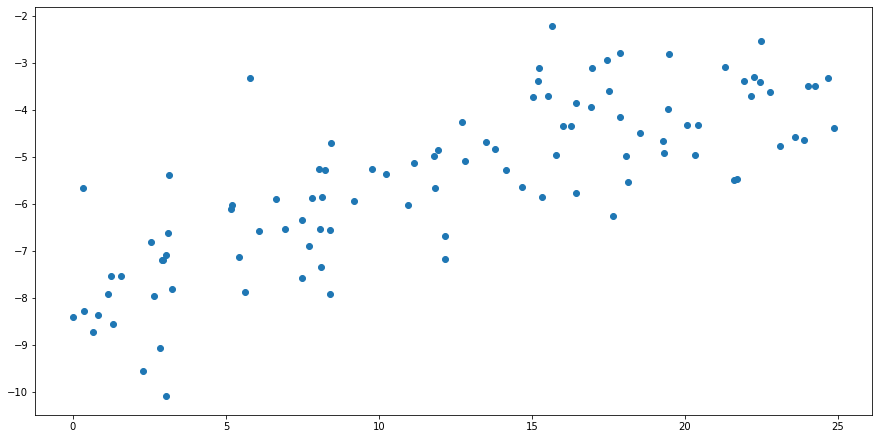

In [2]:
from google.colab import drive
import scipy.io as sio


drive.mount('/content/drive')

plt.figure(figsize = (15,7.5))
txt = '/content/drive/My Drive/trace3_37.mat'
data = sio.loadmat(txt)
val = data['val']
time = data['time']
t = len(val)

plt.scatter(time,val)
plt.show()

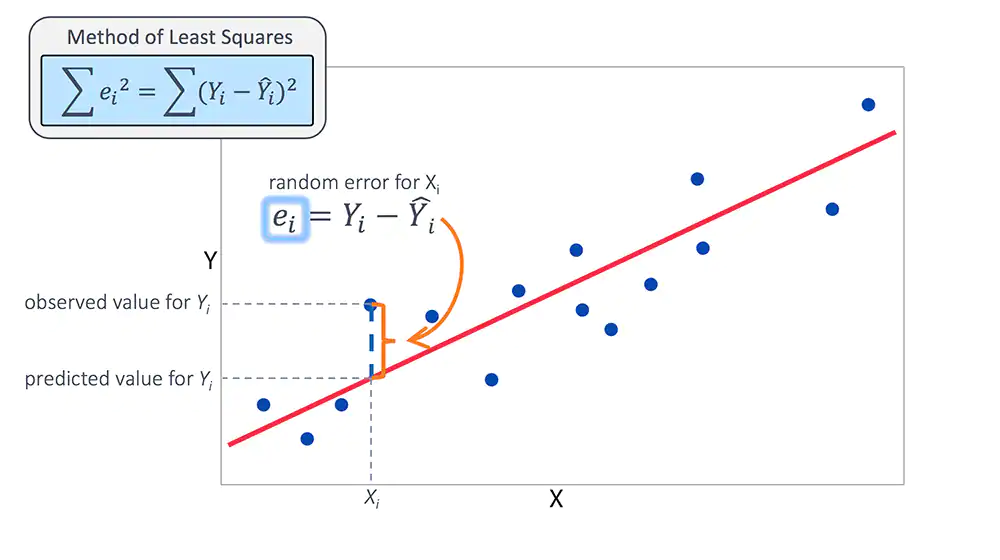

Explicit "naive" implementation in one shot

In [3]:
from sklearn.preprocessing import MinMaxScaler 

mm_scaler = MinMaxScaler()

class Linear:
  def __call__(self, X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    error = ((y_true - y_pred) ** 2).mean()
    return error

X_train = np.array(time.T)
y_train = np.array(val.T)

X_train = mm_scaler.fit_transform(X_train)
y_train = mm_scaler.fit_transform(y_train.reshape(-1,1))

naive_line = Linear()
theta = naive_line(X_train, y_train)

loss_fun = MSE()
y_pred = X_train @ theta
loss_fun(y_train, y_pred)

0.04078464253684813

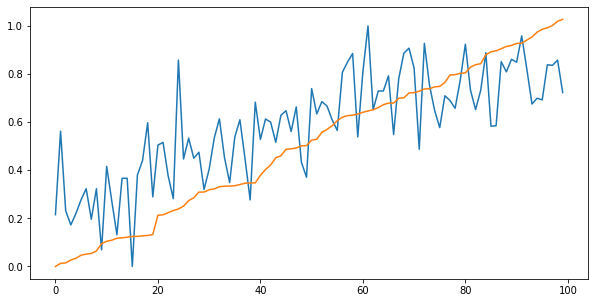

In [4]:
plt.figure(figsize = (10,5))
plt.plot(y_train)
plt.plot(y_pred)

A more accurate computation requires a backpropagation phase for both the error and the weights. This can be achieved using the gradient. An update phase corrects the fit based on minimizing the error with the usage of gradient descent.

In [6]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient


class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  # GD

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

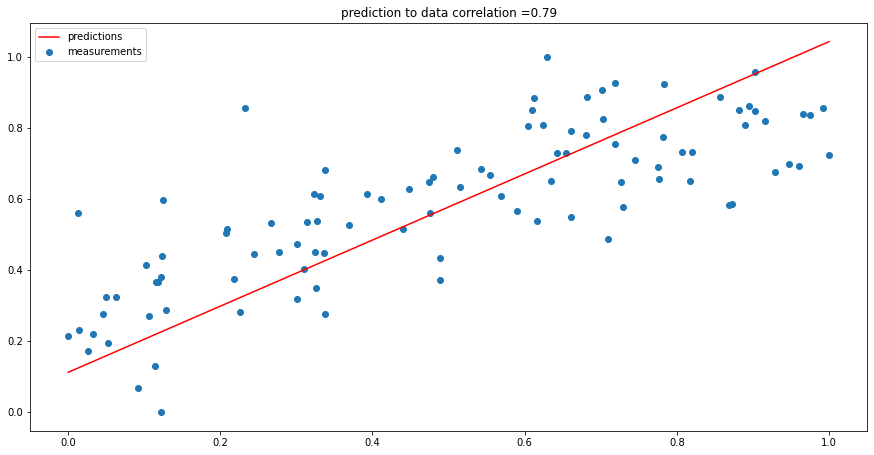

In [20]:
y_true = y_train

loss = MSE()
linear = Linear(1)

num_epochs = 500
lr = 0.01

for epoch in range(num_epochs):
  y_pred = linear(X_train)
  loss_value = loss(y_pred, y_true)

  gradient_from_loss = loss.backward()
  linear.backward(gradient_from_loss)
  linear.update(lr)

plt.figure(figsize = (15,7.5))
plt.scatter(X_train,y_train, label = 'measurements')
plt.plot(X_train,y_pred,'r',label = 'predictions')
plt.title(f'prediction to data correlation ={np.corrcoef(y_train.T, y_pred.T)[0, 1]:.2f}')
plt.legend()

PyTorch Implementation:

In [21]:
import warnings
warnings.filterwarnings("ignore") # for deprecation warnings

time = time.T
val = val.T

x = torch.tensor(time)
y = torch.tensor(val)

x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

x = x.float()
y = y.float()

x= np.expand_dims(x, axis=1)
y= np.expand_dims(y, axis=1)

x = torch.tensor(x)
y = torch.tensor(y)

Note that real life problems need an architecture that is more complex than a simple regression. This may be because of non-Gaussian noise in the dataset, or strong bursts of nonlinearity. The workaround for this can pe a deeper neural network made out of regressions for forward paswses and ReLU's that deal with the nonlinearities for backward propagations. 

Text(0.5, 1.0, 'prediction to data correlation =0.79')

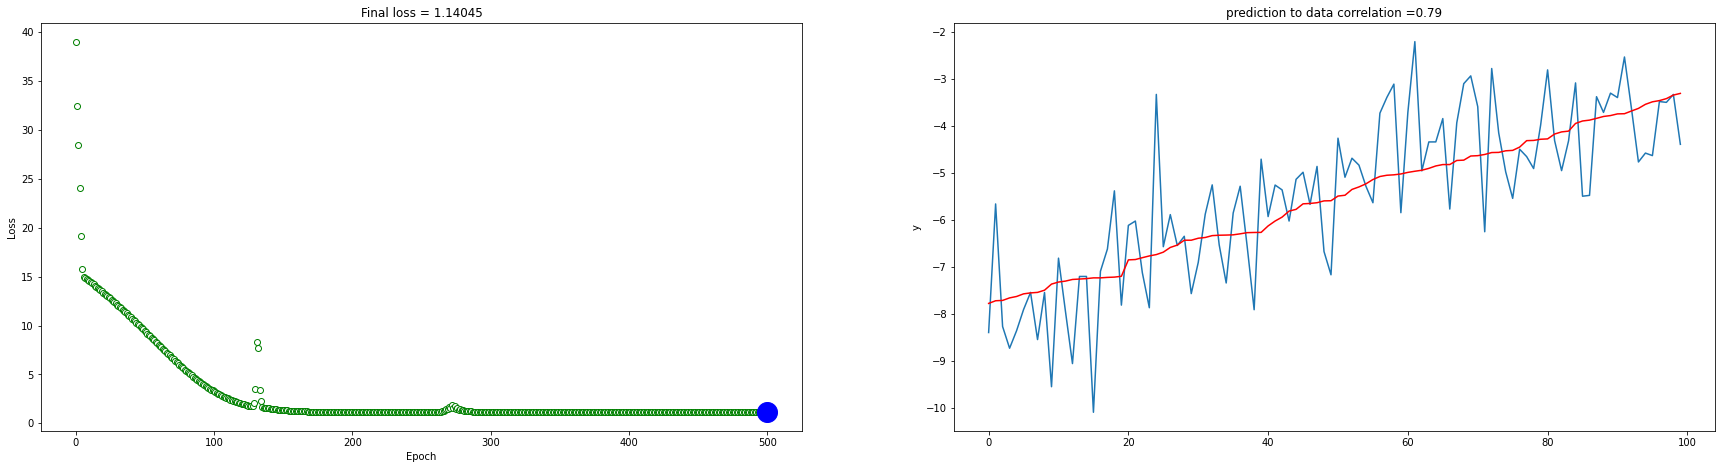

In [22]:
reg = nn.Sequential(nn.Linear(1,1), nn.ReLU(),nn.Linear(1,1), nn.ReLU(), nn.Linear(1,1))

step = .005
lossfcn = nn.MSELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=step)

numepochs = 500
losshist = torch.zeros(numepochs)

for epochi in range(numepochs):

    # forward pass
    yPred = reg(x)

    # loss
    loss = lossfcn(yPred, y)
    losshist[epochi] = loss

    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


prediction = reg(x)

testloss = (prediction - y).pow(2).mean()

fig,ax = plt.subplots(1,2,figsize=(30,7.5))

ax[0].plot(losshist.detach(), 'go', markerfacecolor='w', linewidth=.1)
ax[0].plot(numepochs, testloss.detach(), 'bo', markersize = 20)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Final loss = %g' % testloss.item())

ax[1].plot(y, label='Data')
ax[1].set_ylabel('y')
ax[1].plot(prediction.detach(), 'r', label='Predictions')
ax[1].set_title(f'prediction to data correlation ={np.corrcoef(y.T, prediction.detach().T)[0, 1]:.2f}')
